# Delta Hedging and Monte-Carlo Simulation Pt 2

**Fall 2025 Quantiative Methods in Finance**

**The Erdös Institute**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm


sns.set_style('darkgrid')

### Black-Scholes Equation for Call and Put Options

Let $t > 0$ and assume the distribution of stock prices $S_t$ from time $0$ to time $t$ is the risk-free Geometric Brownian Motion model:

$$
S_t = S_0e^{\left(r - \frac{\sigma^2}{2}\right)t + \sigma\sqrt{t}\,\mathcal{N}(0,1)}.
$$
Where
- $S_0$ is the stock price at time $0$;
- $\sigma$ is yearly standard deviation of log-returns;
- $r$ is the risk-free interest rate;
- $\mathcal{N}(0,1)$ is the standard normal distribution.

Let $\varphi$ and $\Phi$ denote the probability density function (PDF) and cumulative distribution function (CDF) of the standard normal distribution respectively:

$$
\varphi(x) = \frac{e^{-x^2/2}}{\sqrt{2\pi}}\qquad\text{and}\qquad \Phi(y) = \mathbb{P}(\mathcal{N}(0,1) \leq y) = \int_{-\infty}^y\varphi(x) \, dx.
$$



Let $K > 0$ be a strike price. Denote by $C_t = \max(S_t-K,0)$ and $P_t = \max(-S_t+K,0)$ the distriubtion of respective values of a call and a put option expiring in $t$ units of time. Let 

$$C_0 = e^{-rt}\mathbb{E}[\max(S_t-K,0)] \qquad\text{and}\qquad P_0 = e^{-rt}\mathbb{E}[\max(-S_t+K,0)]$$


be the discounted to time $0$ expected values of $C_t$ and $P_t$ respectively. Then

$$
C_0 = S_0\Phi(d_1) - K e^{-rt}\Phi(d_2) \qquad\text{and}\qquad P_0 = -S_0\Phi(-d_1) + K e^{-rt}\Phi(-d_2),
$$

where

$$
d_1 = \frac{\ln\left(\frac{S(0)}{K}\right) + \left(r + \frac{\sigma^2}{2}\right)t}{\sigma \sqrt{t}} \qquad\text{and}\qquad
d_2 = d_1 - \sigma\sqrt{t}.
$$


**Probability of option expiring in-the-money**

The probability that $C_t>0$ and $P_t>0$ respectively is 

$$\mathbb{P}[C_t>0] = \Phi(d2)\qquad\text{and}\qquad \mathbb{P}[P_t>0] = \Phi(-d2).$$

**Relationship between $d_1$ and $d_2$**

The numbers $d_1$ and $d_2$ satisfy the equation:

$$S_0\varphi(d_1) = e^{-rt}\varphi(d_2).$$

## Call-Put Parity

Let $t > 0$ and assume the distribution of stock prices $S_t$ from time $0$ to time $t$ is the risk-free Geometric Brownian Motion model. Let $K > 0$ be a strike price of a call and put option with the same time to expiration $t$. Then 

$$C_0 - P_0 = S_0 - e^{-rt}K.$$



## Delta

The **delta** of an option is the rate of change of the Black-Scholes price of the option with respect to the price of the underlying stock price $S_0$:


$$\Delta_{C_{0}} := \frac{\partial C_0}{\partial S_0} = \Phi(d_1) \qquad\text{and}\qquad \Delta_{P_{0}} := \frac{\partial P_0}{\partial S_0} = -(1-\Phi(d_1)).$$

## Vega

The **vega** of an option is the rate of change of the Black-Scholes price of the option with respect to volatility $\sigma$:

$$\nu_{C_0} :=\frac{\partial C_0}{\partial \sigma} = S_0\varphi(d_1)\sqrt{t} = e^{-rt}K\varphi(d_2)\sqrt{t} = \frac{\partial P_0}{\partial \sigma}=: \nu_{P_0}.$$

In [2]:
#Useful functions

def GBM_paths(S0, sigma, t, r, mu, n_sims, n_steps):
    """Simulates stock paths as geometric Brownian Motions
    Inputs:
    S0 (float): Underlying stock price at time 0
    sigma (float): Yearly volatility
    t (float): Time to expiration (years)
    r (float): Risk-free interest rate
    mu (float): Drift of log-returns
    n_sims (int): Number of simulated paths
    n_steps (int): Number of steps in each simulated path, each step interval has length t/n_steps
    
    Return (np.array): Array of stock paths
    """
    
    dt = t/n_steps
    noise = np.random.normal(loc = 0, scale = 1, size = (n_sims, n_steps))
    log_returns = (mu+r-sigma**2*(0.5))*dt + sigma*np.sqrt(dt)*noise
    exponent = np.cumsum(log_returns, axis = 1)
    paths = S0*np.exp(exponent)
    paths_with_start = np.insert(paths, 0, S0, axis = 1)

    return paths_with_start

def bs_call(S0, K, sigma, t, r):
    '''
    Black-Scholes Call Option formula
    
    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma: Yearly volatility
    t: Time to expiration (years)
    r: Risk-free Interest rate
    
    
    Return:
    Black-Scholes value of call option (float)
    '''
    
    d1 = (np.log(S0/K) + (r + (0.5)*sigma**2)*t)/(sigma*np.sqrt(t))
    
    d2 = d1 - sigma*np.sqrt(t)
    
    
    call_value = S0*norm.cdf(d1) - K*np.exp(-r*t)*norm.cdf(d2)
    
    
    return call_value
    


def bs_put(S0, K, sigma, t, r):
    '''
    Black-Scholes Put Option formula
    
    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma: Yearly volatility
    t: Time to expiration (years)
    r: Risk-free Interest rate
    
    
    Return:
    Black-Scholes value of put option (float)
    '''
    
    d1 = (np.log(S0/K) + (r + (0.5)*sigma**2)*t)/(sigma*np.sqrt(t))
    
    d2 = d1 - sigma*np.sqrt(t)
    
    
    put_value = -S0*norm.cdf(-d1) + K*np.exp(-r*t)*norm.cdf(-d2)
    
    
    return put_value

In [3]:
# Complete functions for option deltas and vegas.

def bs_call_delta(S0, K, sigma, t, r):
    '''Black-Scholes Delta of Call Option
    
    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma: Yearly volatility
    t: Time to expiration (years)
    r: Risk-free Interest rate
    
    
    Return:
    Black-Scholes rate of change of call option with respect to S_0
    
    '''
    
    d1 = (np.log(S0/K) + (r + (0.5)*sigma**2)*t)/(sigma*np.sqrt(t))
    
    
    return norm.cdf(d1)



def bs_put_delta(S0, K, sigma, t, r):
    '''Black-Scholes Delta of Put Option
    
    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma: Yearly volatility
    t: Time to expiration (years)
    r: Risk-free Interest rate
    
    
    Return:
    Black-Scholes rate of change of put option with respect to S_0
    
    '''
    d1 = (np.log(S0/K) + (r + (0.5)*sigma**2)*t)/(sigma*np.sqrt(t))
    
    
    return -1 + norm.cdf(d1)


def bs_vega(S0, K, sigma, t, r):
    '''Black-Scholes vega of Call & Put Options
    
    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma: Yearly volatility
    t: Time to expiration (years)
    r: Risk-free Interest rate
    
    
    Return:
    Black-Scholes rate of change of call & put option with respect to sigma
    
    '''
    
    d1 = (np.log(S0/K) + (r + (0.5)*sigma**2)*t)/(sigma*np.sqrt(t))
    
    
    return S0*norm.pdf(d1)*np.sqrt(t)

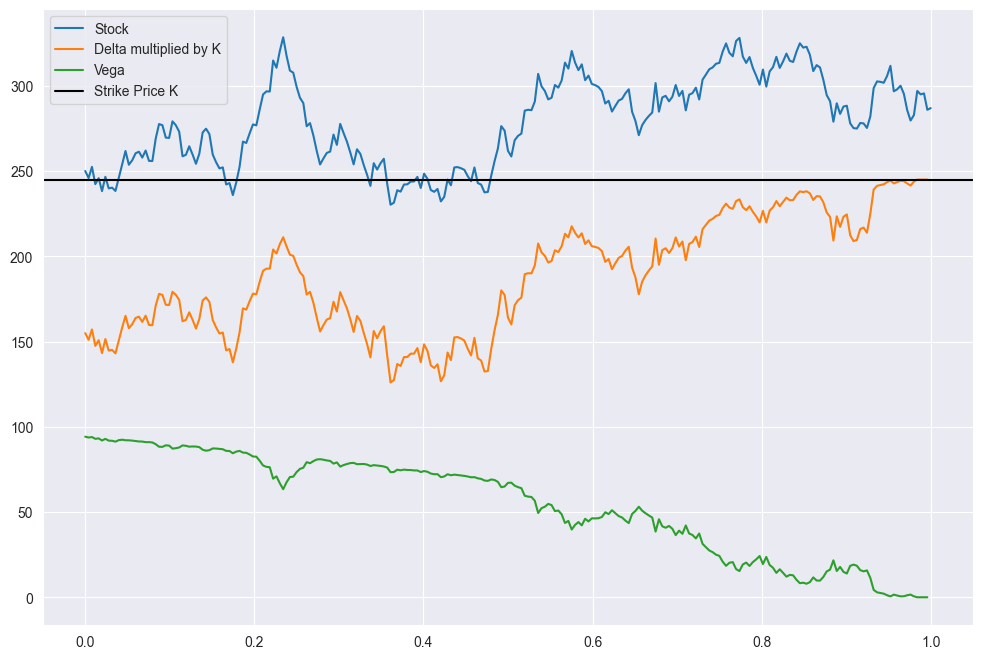

In [29]:
#Simulate Stock Paths and visualize call option and create visual of deltas and vegas through expiration.

S0 = 250

K = 245

sigma = .4

t = 1

r = .035

mu = 0

n_sims = 1

n_steps = 252

stock_path = GBM_paths(S0,sigma, t, r, mu, n_sims, n_steps)[0]



times = np.linspace(0,t, n_steps + 1)


deltas = bs_call_delta(stock_path[:n_steps], K, sigma, (t-times)[:n_steps], r)

vegas = bs_vega(stock_path[:n_steps], K, sigma, (t-times)[:n_steps], r)


plt.figure(figsize = (12,8))

plt.plot(times, stock_path, label = 'Stock')

plt.plot(times[:n_steps], K*deltas, label = 'Delta multiplied by K')

plt.plot(times[:n_steps], vegas, label = 'Vega')


plt.axhline(K, label = 'Strike Price K', color = 'black')


plt.legend()
plt.show()

In [12]:
(t-times)[:n_steps]

array([1. , 0.8, 0.6, 0.4, 0.2])

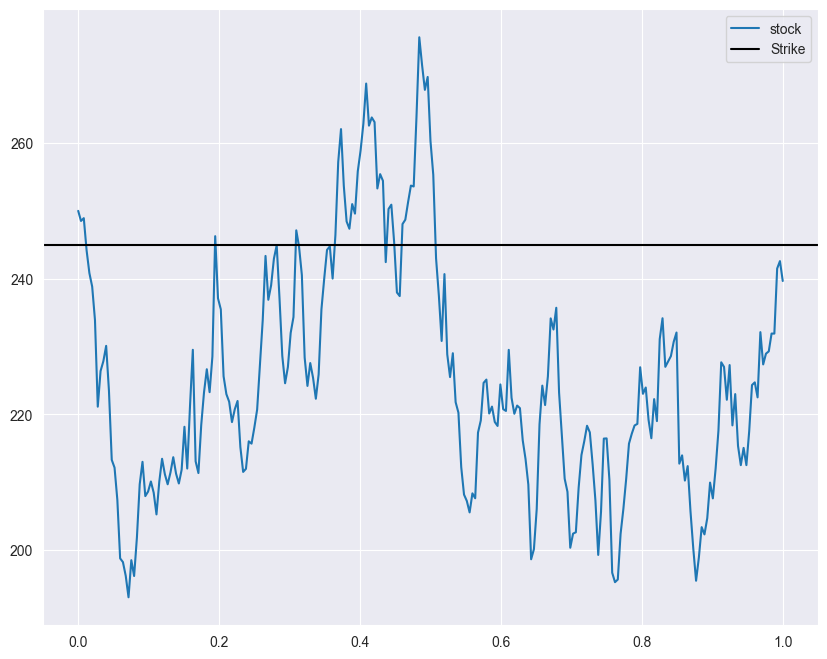

Black-Scholes expected profit: $470.26
----------------------------------------------------------------------------------------------------
Simulated Profit $497.43


In [71]:
#Simulate stock path (allow for drift), and then explore the effect of Delta-hedging from the point of view of 
# a market maker selling an option contract on the market.



S0 = 250

K = 245

sigma = .4

t = 1

r = .035

mu = .08

n_sims = 1

n_steps = 252

stock_path = GBM_paths(S0,sigma, t, r, mu, n_sims, n_steps)[0]


premium = bs_call(S0, K, sigma + .05, t, r)


n_options = 100






times = np.linspace(0,t, n_steps + 1)

dt = t/n_steps



call_payout_discounted = np.maximum(stock_path[-1]-K, 0)*np.exp(-r*t)


deltas = bs_call_delta(stock_path[0:n_steps], K, sigma, (t-times)[0:n_steps], r)


stock_profits_discounted = (stock_path[1:n_steps +1] - \
                            stock_path[0:n_steps]*np.exp(r*dt))*np.exp(-r*times[1:n_steps+1])*deltas


total_stock_profit_discounted = np.sum(stock_profits_discounted)



portfolio_pl = n_options*(premium - call_payout_discounted + total_stock_profit_discounted)


bs_predicted_profit = n_options*(premium-bs_call(S0,K,sigma,t,r))


plt.figure(figsize = (10,8))


plt.plot(times, stock_path, label = 'stock')

plt.axhline(K, label='Strike', color = 'black')


plt.legend()
plt.show()

print(f'Black-Scholes expected profit: ${bs_predicted_profit:.2f}')

print('-'*100)

print(f'Simulated Profit ${portfolio_pl:.2f}')

In [61]:
bs_call(S0, K, sigma + .05, t, r), bs_call(S0, K, sigma, t, r)

(50.34331766996199, 45.64069569198787)

In [ ]:
#Simulate profit distibutions of daily hedging sold option contracts.